In [15]:
from owslib.wcs import WebCoverageService

In [16]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/phh2o.map', version='2.0.1')

In [17]:
cov_id = 'phh2o_0-5cm_mean'
ph_0_5 = wcs.contents[cov_id]
ph_0_5.supportedFormats 

['image/tiff',
 'image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8']

In [18]:
subsets = [('X', -1784000, -1140000), ('Y', 1356000, 1863000)]

In [19]:
crs = "http://www.opengis.net/def/crs/EPSG/0/152160"

In [21]:
response = wcs.getCoverage(
  identifier=cov_id, 
  crs=crs,
  subsets=subsets, 
  resx=250, resy=250, 
  format=ph_0_5.supportedFormats[0])

with open('./Senegal_pH_0-5_mean.tif', 'wb') as file:
  file.write(response.read())

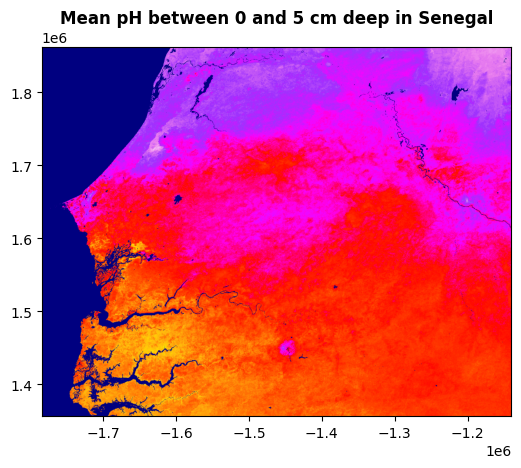

<Axes: title={'center': 'Mean pH between 0 and 5 cm deep in Senegal'}>

In [22]:

import rasterio
from rasterio import plot

ph = rasterio.open("./Senegal_pH_0-5_mean.tif", driver="GTiff")
plot.show(ph, title='Mean pH between 0 and 5 cm deep in Senegal', cmap='gist_ncar')    

In [ ]:
import os
import io
import sys
import logging
import numpy as np
import pandas as pd
from owslib.wcs import WebCoverageService

# Libraries for Coordinate math and Tiff reading
try:
    import rasterio
    from pyproj import Transformer
except ImportError:
    print("❌ Missing libraries. Run: pip install rasterio pyproj OWSLib")
    sys.exit(1)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

try:
    from DSSATTools import SoilProfile, SoilLayer
    from DSSATTools.soil import estimate_from_texture
except ImportError:
    print("❌ DSSATTools not found. Please install it using: pip install DSSATTools")
    sys.exit(1)

# --- Configuration ---
SOILGRIDS_DEPTHS = ["0-5cm", "5-15cm", "15-30cm", "30-60cm", "60-100cm", "100-200cm"]
# Note: nitrogen and phh2o map names often differ slightly in WCS, we handle this below.
SOILGRIDS_PROPERTIES = ["sand", "silt", "clay", "bdod", "cfvo", "soc", "phh2o", "cec", "nitrogen", "wv0033", "wv1500"]

# --- Helper: Coordinate Projection ---
def _latlon_to_homolosine(lat, lon):
    """
    Converts GPS (Lat/Lon) to SoilGrids Native (Homolosine Meters).
    Input: WGS84 (EPSG:4326)
    Output: Interrupted Goode Homolosine (IGH)
    """
    # Define the projection strings
    wgs84 = "EPSG:4326"
    # This is the standard proj string for Goode Homolosine
    igh = "+proj=igh +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"
    
    transformer = Transformer.from_crs(wgs84, igh, always_xy=True)
    x, y = transformer.transform(lon, lat)
    return x, y

def _fetch_owslib_value(prop, depth, x_meter, y_meter):
    """
    Uses OWSLib to fetch a single pixel from the WCS 2.0.1 service.
    """
    # 1. Setup the Service Connection
    # Map filenames are usually just the property name, e.g., 'sand.map'
    map_url = f'http://maps.isric.org/mapserv?map=/map/{prop}.map'
    
    try:
        wcs = WebCoverageService(map_url, version='2.0.1')
        
        # 2. Construct the Coverage ID (e.g., 'sand_0-5cm_mean')
        cov_id = f"{prop}_{depth}_mean"
        
        # Check if this coverage exists in the contents
        if cov_id not in wcs.contents:
            # Sometimes Nitrogen is named 'nitrogen' but the map is 'nitrogen.map'
            logging.warning(f"  ⚠️ Coverage {cov_id} not found in {map_url}")
            return np.nan

        # 3. Define the Subset (The Slice)
        # We want a tiny 1x1 pixel area. SoilGrids resolution is ~250m.
        # We create a small buffer around our center point.
        buffer = 150 # meters
        subsets = [
            ('X', x_meter - buffer, x_meter + buffer),
            ('Y', y_meter - buffer, y_meter + buffer)
        ]

        # 4. Request the Data (GetCoverage)
        response = wcs.getCoverage(
            identifier=cov_id, 
            subsets=subsets, 
            format='image/tiff' # As per snippet logic
        )
        
        # 5. Read the result using Rasterio (in-memory)
        with io.BytesIO(response.read()) as f:
            with rasterio.open(f) as src:
                # Read the first band
                data = src.read(1)
                # Get the center pixel
                val = data[0][0]
                
                # Handle NoData (SoilGrids uses negative numbers for empty space)
                if val < 0: return np.nan
                return float(val)

    except Exception as e:
        logging.warning(f"  ⚠️ WCS Error for {prop} at {depth}: {e}")
        return np.nan

def _get_soilgrids_via_owslib(lat, lon):
    logging.info(f"Connecting to SoilGrids WCS via OWSLib for {lat}, {lon}")
    
    # Convert Coordinates Step
    x, y = _latlon_to_homolosine(lat, lon)
    logging.info(f"  Converted Coords: Lat/Lon ({lat},{lon}) -> Homolosine X/Y ({int(x)}, {int(y)})")

    data_dict = {p: [] for p in SOILGRIDS_PROPERTIES}
    
    for depth in SOILGRIDS_DEPTHS:
        logging.info(f"--> Fetching Depth: {depth}")
        for prop in SOILGRIDS_PROPERTIES:
            val = _fetch_owslib_value(prop, depth, x, y)
            data_dict[prop].append(val)
            
    df = pd.DataFrame(data_dict, index=SOILGRIDS_DEPTHS)
    
    # Check for empty data
    if df.isnull().all().all():
        logging.error("❌ OWSLib failed to retrieve data. Using Fallback.")
        return None
        
    return df

# --- Fallback Generator (Same as before) ---
def _generate_fallback_data():
    logging.warning("⚠️ USING FALLBACK DATA (Red Sandy Loam).")
    mock_values = {
        "sand": 650, "silt": 200, "clay": 150, "bdod": 145, 
        "cfvo": 50, "wv0033": 180, "wv1500": 80, "soc": 80, 
        "phh2o": 65, "cec": 100, "nitrogen": 100
    }
    data = {prop: [val for _ in SOILGRIDS_DEPTHS] for prop, val in mock_values.items()}
    return pd.DataFrame(data, index=SOILGRIDS_DEPTHS)

# --- Main Processing Logic ---
def create_soil_file(lat, lon, output_dir, soil_id):
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s', stream=sys.stdout)
    
    # 1. Fetch Data
    df = _get_soilgrids_via_owslib(lat, lon)
    
    if df is None:
        df = _generate_fallback_data()

    # 2. Process for DSSAT (Unit Conversions)
    logging.info("Converting to DSSAT format...")
    dssat_layers = []
    
    for label, row in df.iterrows():
        # Clean defaults if NaN
        row = row.fillna(0) 
        
        # Create SoilLayer Object
        try:
            lay = SoilLayer(
                slb  = int(label.split('-')[1].replace('cm', '')),
                slcl = row['clay'] / 10,   # g/kg -> %
                slsi = row['silt'] / 10,
                sbdm = row['bdod'] / 100,  # cg/cm3 -> g/cm3
                sloc = row['soc'] / 100,   # dg/kg -> %
                slni = row['nitrogen'] / 100,
                slhw = row['phh2o'] / 10,  # pH x 10 -> pH
                scec = row['cec'] / 10,
                slll = row['wv1500'] / 1000, # Fraction
                sdul = row['wv0033'] / 1000,
                ssat = (row['wv0033'] / 1000) + 0.15, # Estimate saturation
                ssks = 1.0
            )
            dssat_layers.append(lay)
        except Exception as e:
            logging.error(f"Error creating layer {label}: {e}")

    # 3. Create Profile
    top = df.iloc[0]
    sand = 100 - (top['clay']/10) - (top['silt']/10)
    texture_class = "SL" if sand > 50 else "CL" # Simplified classifier
    
    profile = SoilProfile(
        name=soil_id, 
        soil_series_name=f"SG_{texture_class}_OWS", 
        soil_clasification=texture_class,
        site="SoilGrids-OWS", country="India", 
        lat=lat, long=lon,
        table=dssat_layers
    )

    filename = os.path.join(output_dir, f"{soil_id}.SOL")
    with open(filename, 'w') as f:
        f.write(profile._write_sol())
        
    print(f"\n✅ Created: {filename}")
    print(df.head())
    return filename

if __name__ == "__main__":
    # Test Coordinates
    create_soil_file(14.2815, 77.9781, ".", "SG_OWS_TEST")